In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import random
random.seed(0)
import torch
torch.manual_seed(0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device
data = pd.read_csv('/Users/hieudao/Desktop/ai/do_an/clean_data/clean_apple.csv')

In [2]:

data['Date'] = pd.to_datetime(data['Date'])
data = data[ data['Date'] < pd.to_datetime('2023-01-01 00:00:00-04:00')]
data = data[ data['Date'] >= pd.to_datetime('2013-01-01 00:00:00-04:00')]
data['Close+1'] = data['Close'].shift(-1)
data = data.dropna()
data.tail(3)

,Date,Open,High,Low,Close,Volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,...,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,Close+1
10494,2022-12-27 00:00:00-05:00,130.998521,131.028433,128.346242,129.652435,69007800,2.641618,18.464509,41.547614,-100.000000,...,132.909909,2.928490,0.150834,128.346242,134.169275,129.687337,129.680351,137.984687,129.586572,125.674026
10495,2022-12-28 00:00:00-05:00,129.293484,130.649535,125.504522,125.674026,85438400,3.409589,8.852589,52.109435,-100.000000,...,133.780294,7.516627,0.163572,125.504522,132.035499,128.077029,125.750223,137.058611,126.913788,129.233658
10496,2022-12-29 00:00:00-05:00,127.618359,130.101127,127.359119,129.233658,75703700,3.370665,46.341243,59.150649,20.991684,...,131.756586,5.569812,0.646637,125.504522,131.028433,128.730123,128.940210,136.379374,127.354561,129.552719


In [3]:
data = data.drop(columns=['tema_2', 'tema_100'])
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NATR_3', 'RSI_3',
       'ADX_3', 'CCI_3_0.015', 'ROC_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3',
       'WILLR_3', 'OBV', 'MACD_12_26_9', 'BBL_3_2.0', 'BBM_3_2.0', 'BBU_3_2.0',
       'BBB_3_2.0', 'BBP_3_2.0', 'min_price_3', 'max_price_3', 'mid_price',
       'tema_8', 'Close+1'],
      dtype='object')

In [4]:


train = data[data['Date'] < pd.to_datetime('2022-01-01 00:00:00-04:00')]

val = data[data['Date'] < pd.to_datetime('2023-01-01 00:00:00-04:00')]
val = data[data['Date'] >= pd.to_datetime('2022-01-01 00:00:00-04:00')]

train = train.drop(columns=['Date'])
val = val.drop(columns=['Date'])


X_train = train.copy().drop(columns=['Close+1'])
y_train = pd.DataFrame()
y_train['Close+1'] = train[['Close+1']]

X_val = val.copy().drop(columns=['Close+1'])
y_val = pd.DataFrame()
y_val['Close+1'] = val[['Close+1']]
X_train.shape,X_val.shape,y_train.shape,y_val.shape


((2267, 24), (250, 24), (2267, 1), (250, 1))

In [5]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
X_train.shape, X_val.shape


((2267, 24), (250, 24))

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_train_scaled.shape, X_val_scaled.shape


((2267, 24), (250, 24))

In [7]:
from torch.utils.data import DataLoader,Dataset
sequence_length= 5
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y,sequence_length=5):
        self.X =  torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.sequence_length = sequence_length
    def __len__(self):
        return len(self.X)

    def __getitem__(self, i): 
       
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        elif self.sequence_length==1:
            return self.X[i],self.y[i]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            #print(padding.shape, x.shape)
            x = torch.cat((padding, x), 0)
            # x = self.X[0:i, :]
            #print(x.shape,padding.shape)

        return x, self.y[i]
       
train_dataset = TimeSeriesDataset(X_train_scaled, y_train, sequence_length=sequence_length)
val_dataset = TimeSeriesDataset(X_val_scaled, y_val, sequence_length=sequence_length)

In [8]:

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(24, 64, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(24, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
losses = []
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    train_loss = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    print(f"train Error: Avg loss: {train_loss/num_batches:>8f}")
    losses.append((train_loss/num_batches))

In [12]:
val = []
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    val.append(test_loss)
    
    scheduler.step()
    #curr_lr = optimizer.param_groups[0]['lr']

    print(f"Test Error: Avg loss: {test_loss:>8f}  \n")

In [13]:
from torch.optim.lr_scheduler import StepLR

learning_rate = 0.01
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=200, gamma=0.1)

epochs = 2000
for t in range(epochs):
    if epochs %100==0:
        
        print(f"Epoch {t+1}\n-------------------------------")
    
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(val_loader, model, loss_fn)
print("Done!")




Epoch 1
-------------------------------
train Error: Avg loss: 2826.809993
Test Error: Avg loss: 16118.282959  

Epoch 2
-------------------------------
train Error: Avg loss: 2009.796015
Test Error: Avg loss: 13422.695801  

Epoch 3
-------------------------------
train Error: Avg loss: 1854.479949
Test Error: Avg loss: 12034.916504  

Epoch 4
-------------------------------
train Error: Avg loss: 1827.538117
Test Error: Avg loss: 11257.717773  

Epoch 5
-------------------------------
train Error: Avg loss: 1512.282808
Test Error: Avg loss: 9718.038086  

Epoch 6
-------------------------------
train Error: Avg loss: 1302.005397
Test Error: Avg loss: 8839.715576  

Epoch 7
-------------------------------
train Error: Avg loss: 1513.502959
Test Error: Avg loss: 10019.902100  

Epoch 8
-------------------------------
train Error: Avg loss: 948.646168
Test Error: Avg loss: 6630.499756  

Epoch 9
-------------------------------
train Error: Avg loss: 826.498981
Test Error: Avg loss: 6248

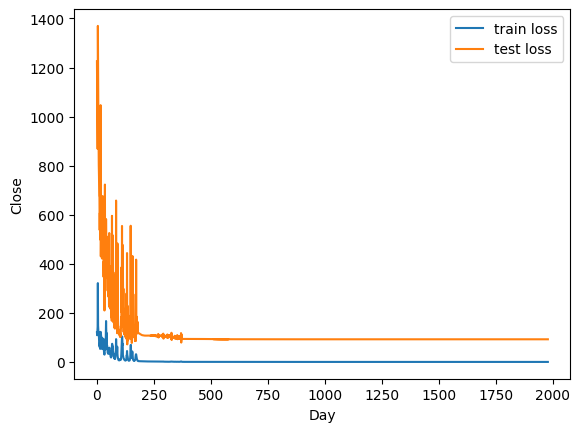

In [14]:
plt.plot(losses[20:], label='train loss')
plt.plot(val[20:], label='test loss')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

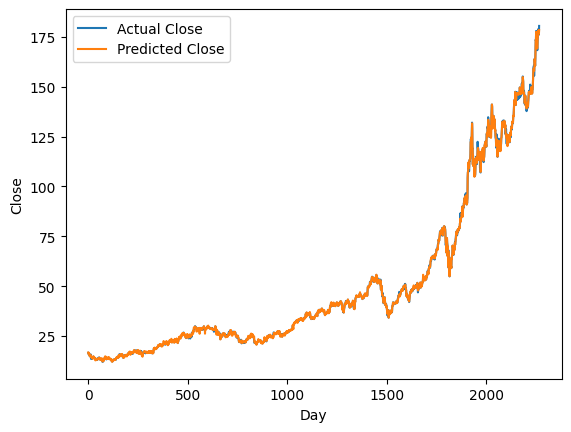

(tensor([120.7457]), array([120.60674286]))

In [15]:


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
count =0
output = torch.tensor([])
model.eval()
with torch.no_grad():
    for X, y in train_loader:
        y_star = model(X)
        output = torch.cat((output, y_star), 0)
        
        #print(X.shape,y.shape )
        #print(X.shape)
#print(count)
plt.plot(y_train, label='Actual Close')
plt.plot(output, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
output[2000],y_train[2000]

torch.Size([64, 5, 24]) torch.Size([64, 1])
torch.Size([64, 5, 24]) torch.Size([64, 1])
torch.Size([64, 5, 24]) torch.Size([64, 1])
torch.Size([58, 5, 24]) torch.Size([58, 1])


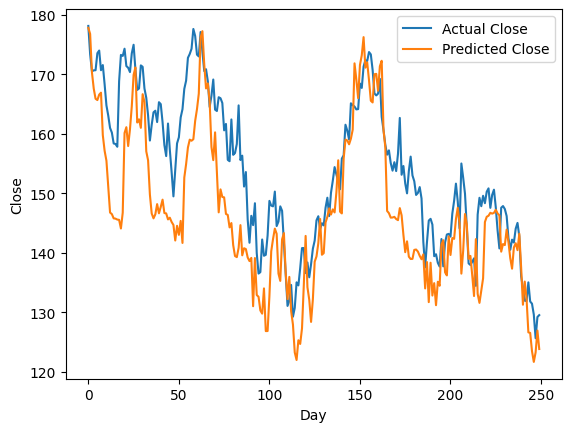

In [16]:

output = torch.tensor([])
model.eval()
with torch.no_grad():
    for X, y in val_loader:
        y_star = model(X)
        output = torch.cat((output, y_star), 0)
        print(X.shape,y.shape )
plt.plot(y_val, label='Actual Close')
plt.plot(output, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [17]:
for batch, (X, y) in enumerate(train_dataset):
    print( (X.shape, y.shape))
    print( batch,(X, y))
    break

(torch.Size([5, 24]), torch.Size([1]))
0 (tensor([[-0.8327, -0.8351, -0.8389, -0.8365,  2.9628,  1.3271,  1.1751,  0.3802,
          1.1056,  2.1106, -0.1353, -0.8181,  1.0276, -0.4912, -0.5962, -0.8696,
         -0.8510, -0.8328,  2.8687,  0.9830, -0.8611, -0.8382, -0.8370, -0.8459],
        [-0.8327, -0.8351, -0.8389, -0.8365,  2.9628,  1.3271,  1.1751,  0.3802,
          1.1056,  2.1106, -0.1353, -0.8181,  1.0276, -0.4912, -0.5962, -0.8696,
         -0.8510, -0.8328,  2.8687,  0.9830, -0.8611, -0.8382, -0.8370, -0.8459],
        [-0.8327, -0.8351, -0.8389, -0.8365,  2.9628,  1.3271,  1.1751,  0.3802,
          1.1056,  2.1106, -0.1353, -0.8181,  1.0276, -0.4912, -0.5962, -0.8696,
         -0.8510, -0.8328,  2.8687,  0.9830, -0.8611, -0.8382, -0.8370, -0.8459],
        [-0.8327, -0.8351, -0.8389, -0.8365,  2.9628,  1.3271,  1.1751,  0.3802,
          1.1056,  2.1106, -0.1353, -0.8181,  1.0276, -0.4912, -0.5962, -0.8696,
         -0.8510, -0.8328,  2.8687,  0.9830, -0.8611, -0.8382, -

In [18]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(output,y_val))

9.689274236175313

In [19]:
data = pd.read_csv('/Users/hieudao/Desktop/ai/do_an/clean_data/clean_apple.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['Close+1'] = data['Close'].shift(-1)
data = data.dropna()

test = data[data['Date'] >= pd.to_datetime('2023-01-01 00:00:00-04:00')]
test = test.drop(columns=['Date','tema_2','tema_100'])
test

,Open,High,Low,Close,Volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBL_3_2.0,BBM_3_2.0,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_8,Close+1
10498,129.901704,130.519898,123.809445,124.706833,112117500,4.067464,22.405448,73.412177,-100.000000,-0.769605,...,123.405058,127.831070,132.257082,6.924783,0.147060,123.809445,130.519898,127.164672,125.886303,125.993095
10499,126.521555,128.286420,124.716813,125.993095,89113600,3.433518,36.223387,79.201037,-50.416864,-2.507522,...,122.651668,126.750882,130.850097,6.468143,0.407569,123.809445,130.519898,126.501617,125.438634,124.656975
10500,126.760849,127.398990,124.397735,124.656975,80962700,2.938965,28.355520,83.429230,-100.000000,-3.778959,...,123.882094,125.118968,126.355841,1.977116,0.313242,123.809445,130.519898,125.898362,124.591764,129.243622
10501,125.644111,129.911675,124.527360,129.243622,87754700,3.500343,66.180390,62.498965,100.000000,3.637963,...,122.779047,126.631231,130.483415,6.084098,0.839079,124.397735,129.911675,127.219517,126.632099,129.772079
10502,130.091158,133.022623,129.512840,129.772079,70790800,3.199059,69.008185,62.336225,100.000000,2.999358,...,123.297133,127.890892,132.484651,7.183872,0.704755,124.397735,133.022623,131.267732,128.232109,130.350403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10620,189.080002,190.070007,188.940002,189.589996,46347300,0.990360,82.130415,70.421457,74.977544,2.331728,...,187.654737,188.966665,190.278593,1.388529,0.737563,185.669998,190.070007,189.505005,189.377760,193.970001
10621,191.630005,194.479996,191.259995,193.970001,85069600,1.744503,93.782080,78.988970,100.000000,3.142616,...,186.637909,190.936666,195.235423,4.502809,0.852815,187.600006,194.479996,192.869995,192.133046,192.460007
10622,193.779999,193.880005,191.759995,192.460007,31458200,1.453242,70.134070,84.700645,38.282485,1.696173,...,188.373397,192.006668,195.639939,3.784526,0.562387,188.940002,194.479996,192.820000,192.887167,191.330002
10623,191.570007,192.979996,190.619995,191.330002,46920300,1.347648,54.661777,68.426905,-100.000000,0.917773,...,190.423689,192.586670,194.749651,2.246241,0.209505,190.619995,194.479996,191.799995,192.610507,191.809998


/usr/local/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


torch.Size([64, 5, 24]) torch.Size([64, 1])
torch.Size([63, 5, 24]) torch.Size([63, 1])


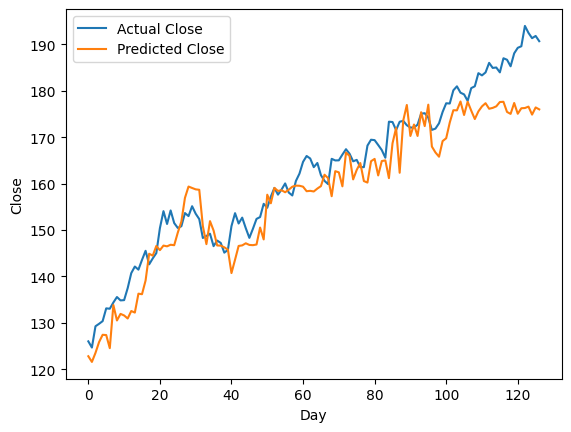

6.306184539539655

In [20]:



X_test = test.copy().drop(columns=['Close+1'])
y_test = pd.DataFrame()
y_test['Close+1'] = test[['Close+1']]

#X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

X_test_scaled = scaler.transform(X_test)

test_dataset = TimeSeriesDataset(X_test_scaled,y_test,sequence_length=sequence_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


output = torch.tensor([])
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        y_star = model(X)
        output = torch.cat((output, y_star), 0)
        
        print(X.shape,y.shape )
#print(count)
plt.plot(y_test, label='Actual Close')
plt.plot(output, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
np.sqrt(mean_squared_error(output,y_test))


In [21]:
y_test.shape, X_test_scaled.shape, output.shape

((127, 1), (127, 24), torch.Size([127, 1]))